In [83]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import pandas as pd
# import umap
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pylab as plt

/nobackup/users/razgaon/projects/condas/cytof/miniconda3/envs/cytof/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# latent = torch.load('latent.pt')
dfz = pd.read_pickle('latent.pickle')
z_markers = dfz.columns

In [3]:
df = pd.read_pickle('x_train.pickle')
x_markers = df.columns

In [4]:
# Make a umap of the latent space
def computeUMAProjectionOfLatentSpace(df, display=True):
    
    df = df.sample(1000)
    latent = df.drop(columns=["source"])

    # Compute t-SNE embedding of latent space
    print("Computing umap embedding...")
    model = umap.UMAP(n_components=2, random_state=0)
    X_umap = model.fit_transform(latent)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting umap visualization...")
        plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df.source)
        plt.show()
    else:
        return X_umap

Computing umap embedding...
Plotting umap visualization...


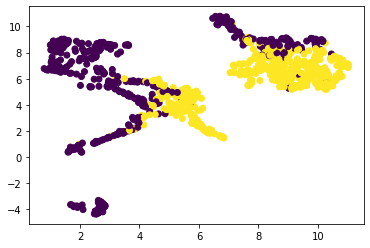

In [61]:
computeUMAProjectionOfLatentSpace(df)

Computing umap embedding...
Plotting umap visualization...


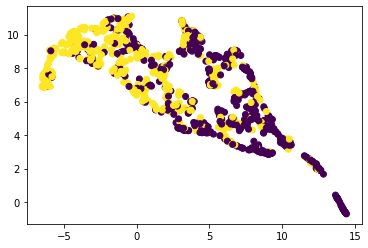

In [62]:
computeUMAProjectionOfLatentSpace(dfz)

In [5]:
# Step 1: Get the distances matrix
sample = dfz.sample(1000)
sample_clean = sample.drop(columns=["source"])
nrst_neigh = NearestNeighbors(n_neighbors = 100, algorithm = 'auto')
nrst_neigh.fit(sample_clean)
distances, indices = nrst_neigh.kneighbors(sample_clean)


In [6]:
indices

array([[  0, 454,  55, ..., 756, 979,  72],
       [  1, 124, 665, ..., 401, 427, 607],
       [  2, 800, 319, ..., 669, 508, 315],
       ...,
       [997,  79,  48, ..., 930, 768, 691],
       [998, 558, 767, ..., 622, 599, 743],
       [999, 670, 838, ..., 544, 431, 150]])

In [7]:
indices_df = pd.DataFrame(indices, index=sample_clean.index, dtype="Int64")
indices_df['source'] = sample.source
indices_df.to_csv('nn_indices.csv')

distances_df = pd.DataFrame(distances, index=sample_clean.index)
distances_df['source'] = sample.source
distances_df.to_csv('nn_distances.csv')


/tmp/ipykernel_4089850/2852484137.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  indices_df['source'] = sample.source


In [8]:
def transform_indices(indices_df):    
    # Transforms indices of nearest neighbors from sample.
    indices_new = np.array([indices_df.index[x] for x in indices_df.values.flatten()]).reshape(indices_df.shape)
    indices_new = pd.DataFrame(indices_new, index=indices_df.index)
    return indices_new



In [9]:
indices_df = transform_indices(pd.read_csv('nn_indices.csv', index_col="Unnamed: 0"))

In [10]:
# indices_df

pbmc_samples = indices_df[sample.source==0]
pbmc_ids = list(pbmc_samples.index)

nsclc_samples = indices_df[sample.source==1]
nsclc_ids = list(nsclc_samples.index)

pbmc_indices = pbmc_samples.replace(pbmc_ids, np.NaN)
nsclc_indices = nsclc_samples.replace(nsclc_ids, np.NaN)



In [77]:
ori = pd.read_csv("original_df.csv", index_col="Unnamed: 0")
ori = ori.drop(columns=['id', 'Time', 'Eventlength', 'sample'])
# ori = ori.drop_duplicates(subset=[index])
ori = ori[~ori.index.duplicated(keep='first')]

In [81]:
ori_pbmc = ori.loc[pbmc_ids,:]
ori_nsclc = ori.loc[nsclc_ids,:]

In [82]:
pbmc_sample = pbmc_ids[0]
sample_neighbors = [int(x) for x in pbmc_indices.loc[pbmc_sample,:].dropna()]
imputed = ori_nsclc.loc[sample_neighbors,:].mean().to_dict()


/tmp/ipykernel_4089850/3160878270.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  imputed = ori_nsclc.loc[sample_neighbors,:].mean().to_dict()


In [69]:
# indices_df['source'] = sample.source
# indices_df = indices_df.drop_duplicates()

In [84]:
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.DataFrame(columns=ori.columns)
for x in list(indices_df.index)[:10]:
    sample = ori.loc[x]
    nn_indices = indices_df.loc[x,:].dropna() 
    neighbors = ori.loc[nn_indices,:]
    # Get the markers that need to be imputed
    missing_markers = list(sample[sample.isna()].index)
    
    # Get the mean for each marker from the neighbors 
    imputed_markers = neighbors[missing_markers].mean()
    # Assign the missing markers with the imputed ones
    sample.loc[missing_markers] = imputed_markers
    # Add to a new dataframe to not modify the data
    df = pd.concat([df, pd.DataFrame(sample).T])
df

,CD11b,Beads,CD80,FoxP3,CD33,CXCR5,CCR6,Gata3,RORgT,CD45RA,...,CCR7,Er168Di,CD38,GITR,CD56,Yb176Di,Os189Di,DNA1,DNA2,Cisplatin
850477,0.073206,0.147239,0.055962,0.173776,0.03314,0.128333,0.0,0.274045,0.0,0.494567,...,0.146083,0.014036,0.11203,0.076676,0.11886,0.11874,0.033254,0.471903,0.406621,0.288264
908934,0.106763,0.0,0.0,0.150754,0.0,0.128333,0.03976,0.167311,0.047917,0.654954,...,0.137269,0.026582,0.110408,0.060431,0.132293,0.132263,0.021272,0.455202,0.381635,0.283604
1096500,0.037292,0.0,0.0,0.213631,0.0,0.0,0.569967,0.431376,0.094063,0.129504,...,0.098808,0.069345,0.044303,0.019831,0.049122,0.051715,0.015593,0.441332,0.348372,0.20035
780435,0.0,0.051431,0.0,0.311034,0.0,0.0,0.146614,0.345195,0.30121,0.727221,...,0.108222,0.069999,0.084492,0.028698,0.080927,0.080056,0.015383,0.384529,0.299045,0.261981
27973,0.169634,0.014248,0.059912,0.257865,0.182228,0.0,0.0,0.205616,0.084792,0.515507,...,0.0,0.040897,0.089465,0.0,0.493083,0.493689,0.0,0.414037,0.320788,0.265712
397902,0.383834,0.0,0.0,0.321539,0.509755,0.034802,0.113827,0.192862,0.348153,0.490285,...,0.140038,0.0271,0.094866,0.095968,0.118034,0.118191,0.031808,0.493999,0.427327,0.304739
120601,0.207145,0.049618,0.087075,0.254255,0.341609,0.0,0.112571,0.221759,0.148403,0.229977,...,0.0,0.0,0.17628,0.0,0.0,0.0,0.0,0.320756,0.204612,0.175464
172515,0.0,0.0,0.0,0.287994,0.208321,0.0,0.07805,0.431376,0.13718,0.0,...,0.119844,0.042021,0.074356,0.02648,0.049057,0.050105,0.011474,0.399876,0.311833,0.209365
1067740,0.037292,0.0,0.0,0.388688,0.122204,0.0,0.113827,0.388207,0.212556,0.761406,...,0.108222,0.071318,0.083788,0.028698,0.085117,0.084246,0.015383,0.389179,0.302991,0.263491
935059,0.521119,0.051431,0.055962,0.287994,0.521841,0.099635,0.0,0.07404,0.245016,0.072507,...,0.143185,0.041803,0.087432,0.036971,0.059163,0.059299,0.003741,0.428614,0.348915,0.267418


In [ ]:
#take a sample from df1, only look at markers that actually exist (non-NaNs)
#find neighbors that belong to df1
#calculate the mean of df1 for all neighbors
#compare that mean to the real value of that existing marker
#calculate difference

,CD11b,Beads,CD80,FoxP3,CD33,CXCR5,CCR6,Gata3,RORgT,CD45RA,...,CCR7,Er168Di,CD38,GITR,CD56,Yb176Di,Os189Di,DNA1,DNA2,Cisplatin
850477,0.073206,0.147239,0.055962,0.173776,0.03314,0.128333,0.0,0.274045,0.0,0.494567,...,0.128712,0.014964,0.118036,0.06488,0.122615,0.123068,0.032886,0.466789,0.399442,0.28237
908934,0.106763,0.0,0.0,0.150754,0.0,0.128333,0.03976,0.167311,0.047917,0.654954,...,0.114338,0.02385,0.131119,0.055776,0.13713,0.137671,0.021128,0.457956,0.384627,0.280108
1096500,0.037292,0.0,0.0,0.213631,0.0,0.0,0.569967,0.431376,0.094063,0.129504,...,0.097101,0.077369,0.053365,0.030026,0.046881,0.049033,0.015566,0.437042,0.345216,0.209699
780435,0.0,0.051431,0.0,0.311034,0.0,0.0,0.146614,0.345195,0.30121,0.727221,...,0.099835,0.071409,0.107402,0.041764,0.083585,0.082354,0.017653,0.386889,0.304382,0.24672
27973,0.169634,0.014248,0.059912,0.257865,0.182228,0.0,0.0,0.205616,0.084792,0.515507,...,0.0,0.040897,0.089465,0.0,0.493083,0.493689,0.0,0.414037,0.320788,0.265712
397902,0.383834,0.0,0.0,0.321539,0.509755,0.034802,0.113827,0.192862,0.348153,0.490285,...,0.130385,0.030514,0.091308,0.078831,0.123153,0.12247,0.039192,0.478308,0.408414,0.276599
120601,0.207145,0.049618,0.087075,0.254255,0.341609,0.0,0.112571,0.221759,0.148403,0.229977,...,0.0,0.0,0.17628,0.0,0.0,0.0,0.0,0.320756,0.204612,0.175464
172515,0.0,0.0,0.0,0.287994,0.208321,0.0,0.07805,0.431376,0.13718,0.0,...,0.118074,0.041516,0.077039,0.027082,0.048013,0.048954,0.016507,0.399825,0.311079,0.209519
1067740,0.037292,0.0,0.0,0.388688,0.122204,0.0,0.113827,0.388207,0.212556,0.761406,...,0.10233,0.068989,0.108935,0.042808,0.087299,0.086037,0.018095,0.390852,0.307828,0.249369
935059,0.521119,0.051431,0.055962,0.287994,0.521841,0.099635,0.0,0.07404,0.245016,0.072507,...,0.136124,0.03551,0.112227,0.04447,0.056243,0.056355,0.009145,0.422157,0.341412,0.255997


In [37]:
x = 27973
sample = ori.loc[x]
nn_indices = indices_df.loc[x,:].dropna() 
neighbors = ori.loc[nn_indices,:]
# Get the markers that need to be imputed
missing_markers = list(sample[sample.isna()].index)

# Get the mean for each marker from the neighbors 
imputed_markers = neighbors[missing_markers].mean()
# Assign the missing markers with the imputed ones
sample.loc[missing_markers] = imputed_markers
pd.DataFrame(sample.T)
    # Add to a new dataframe to not modify the data
#     df = pd.concat([df, sample])

,27973
CD11b,0.169634
Beads,0.014248
CD80,0.059912
FoxP3,0.257865
CD33,0.182228
...,...
Yb176Di,0.493689
Os189Di,0.0
DNA1,0.414037
DNA2,0.320788


In [ ]:
def imputer(indices, ori):
    '''Impute the missing values
    Indices: from a given
    '''
    neighors = [int(x) for x in indices.loc[]]

In [239]:
d = ori_pbmc.loc[pbmc_sample]
# pd.concat([d, imputed]).fillna()
missing_markers = list(d[d.isna()].index)
d.loc[missing_markers] = imputed[missing_markers].mean()
d
# d[disna()]]
# .replace(lambda x: imputed[x])

/nobackup/users/razgaon/projects/condas/cytof/miniconda3/envs/cytof/lib/python3.9/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()
/nobackup/users/razgaon/projects/condas/cytof/miniconda3/envs/cytof/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


CD11b         0.41056
Beads             0.0
CD80         0.055962
FoxP3        0.483183
CD33         0.686255
               ...   
Yb176Di      0.027416
Os189Di      0.027409
DNA1         0.389873
DNA2         0.305809
Cisplatin    0.191282
Name: 631061, Length: 89, dtype: object